In [ ]:
%pip install -q -U datasets evaluate accelerate python-iso639

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

Make sure to mount Google Drive at `/content/drive`.

Also make sure the util scripts are added to the path that is used in `sys.path.append`.

In [ ]:
from dataclasses import dataclass, asdict
from typing import Any
import datetime
import sys

import datasets
import transformers
from transformers import AutoModel, Trainer, AutoModelForAudioClassification, TrainingArguments, AutoFeatureExtractor
from torch.utils.data import DataLoader
import torch
import evaluate
from tqdm.auto import trange, tqdm
import numpy as np
import iso639
import matplotlib.pyplot as plt

sys.path.append("/content/drive/MyDrive/Colab Notebooks")
import global_id_utils

In [20]:
timestamp_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = "/content/drive/MyDrive/LangId Evaluation/minds-14_sanchit-ghandi-whisper-medium-fleurs-lang-id/" + timestamp_str + "/"

# Load model

In [ ]:
model_id = "sanchit-gandhi/whisper-medium-fleurs-lang-id"
model = AutoModelForAudioClassification.from_pretrained(model_id)
# model.to_bettertransformer()
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/615M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

Create mappings to/from model ids to global ids to make using other datasets on this model easier. We create a common interface that allows translation to a single target.

In [ ]:
# This model was trained in google/fleurs, so we can reuse the mappings from the dataset
# Copied from https://huggingface.co/datasets/google/fleurs/blob/main/fleurs.py
from collections import OrderedDict
FLEURS_LANG_TO_ID = OrderedDict([("Afrikaans", "af"), ("Amharic", "am"), ("Arabic", "ar"), ("Armenian", "hy"), ("Assamese", "as"), ("Asturian", "ast"), ("Azerbaijani", "az"), ("Belarusian", "be"), ("Bengali", "bn"), ("Bosnian", "bs"), ("Bulgarian", "bg"), ("Burmese", "my"), ("Catalan", "ca"), ("Cebuano", "ceb"), ("Mandarin Chinese", "cmn_hans"), ("Cantonese Chinese", "yue_hant"), ("Croatian", "hr"), ("Czech", "cs"), ("Danish", "da"), ("Dutch", "nl"), ("English", "en"), ("Estonian", "et"), ("Filipino", "fil"), ("Finnish", "fi"), ("French", "fr"), ("Fula", "ff"), ("Galician", "gl"), ("Ganda", "lg"), ("Georgian", "ka"), ("German", "de"), ("Greek", "el"), ("Gujarati", "gu"), ("Hausa", "ha"), ("Hebrew", "he"), ("Hindi", "hi"), ("Hungarian", "hu"), ("Icelandic", "is"), ("Igbo", "ig"), ("Indonesian", "id"), ("Irish", "ga"), ("Italian", "it"), ("Japanese", "ja"), ("Javanese", "jv"), ("Kabuverdianu", "kea"), ("Kamba", "kam"), ("Kannada", "kn"), ("Kazakh", "kk"), ("Khmer", "km"), ("Korean", "ko"), ("Kyrgyz", "ky"), ("Lao", "lo"), ("Latvian", "lv"), ("Lingala", "ln"), ("Lithuanian", "lt"), ("Luo", "luo"), ("Luxembourgish", "lb"), ("Macedonian", "mk"), ("Malay", "ms"), ("Malayalam", "ml"), ("Maltese", "mt"), ("Maori", "mi"), ("Marathi", "mr"), ("Mongolian", "mn"), ("Nepali", "ne"), ("Northern-Sotho", "nso"), ("Norwegian", "nb"), ("Nyanja", "ny"), ("Occitan", "oc"), ("Oriya", "or"), ("Oromo", "om"), ("Pashto", "ps"), ("Persian", "fa"), ("Polish", "pl"), ("Portuguese", "pt"), ("Punjabi", "pa"), ("Romanian", "ro"), ("Russian", "ru"), ("Serbian", "sr"), ("Shona", "sn"), ("Sindhi", "sd"), ("Slovak", "sk"), ("Slovenian", "sl"), ("Somali", "so"), ("Sorani-Kurdish", "ckb"), ("Spanish", "es"), ("Swahili", "sw"), ("Swedish", "sv"), ("Tajik", "tg"), ("Tamil", "ta"), ("Telugu", "te"), ("Thai", "th"), ("Turkish", "tr"), ("Ukrainian", "uk"), ("Umbundu", "umb"), ("Urdu", "ur"), ("Uzbek", "uz"), ("Vietnamese", "vi"), ("Welsh", "cy"), ("Wolof", "wo"), ("Xhosa", "xh"), ("Yoruba", "yo"), ("Zulu", "zu")])
FLEURS_LANG_SHORT_TO_LONG = {v: k for k, v in FLEURS_LANG_TO_ID.items()}

In [ ]:
model_id_to_global_id = {
    model_id: global_id_utils.language_to_global_id(FLEURS_LANG_TO_ID[model.config.id2label[model_id]].split("_")[0])
    for model_id in model.config.id2label
}

In [ ]:
global_id_to_model_id = {v:k for k, v in model_id_to_global_id.items()}

# Load and preprocess data

In [ ]:
# On Google Colab cpu, runs at about 0.04 it/s, so 200 will over 1.25 hours
minds_14 = datasets.load_dataset("PolyAI/minds14", "all", split="train").shuffle(seed=42).select(range(5))
minds_14

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 5
})

The label names in minds14 are ISO 639-1 codes with the locale (country) afterwards, separated by a hyphen ("en-us"). We take just the language code and use that to create the global id.

The label for Chinese Mandarin in `minds14` is "zh" while the label in `whipser-medium-fleurs-lang-id` is "cmn". Add a custom mapping to fix that discrepency.

In [ ]:
minds_int2str = minds_14.features["lang_id"]._int2str
minds_str2int = minds_14.features["lang_id"]._str2int

In [ ]:
dataset_id_to_global_id = {
    dataset_id: global_id_utils.iso639_part3_to_global_id(
        iso639.Language.from_part1(minds_int2str[dataset_id].split("-")[0]).part3)
    for dataset_id in minds_14.features["lang_id"]._str2int.values()
}
dataset_id_to_global_id[minds_str2int["zh-CN"]] = global_id_utils.iso639_part3_to_global_id("cmn")

Verify that all dataset languages map to a language in the model.

In [ ]:
for name in minds_14.features["lang_id"].names:
  dataset_id = minds_14.features["lang_id"]._str2int[name]
  global_id = dataset_id_to_global_id[dataset_id]
  if global_id not in global_id_to_model_id:
    print(f"Warning: The language {name} (id {dataset_id}) in the dataset does not map to an id in the model."
    + "\nAdd a custom entry to the global_id_to_model_id dictionary")

In [ ]:
minds_14 = minds_14.remove_columns(["path", "transcription", "english_transcription", "intent_class"])

In [ ]:
minds_14 = minds_14.cast_column("audio", datasets.Audio(sampling_rate=16000))

In [ ]:
def preprocess(sample):
  new_sample = feature_extractor(sample["audio"]["array"], sampling_rate=16_000, return_tensors="pt")
  new_sample["input_features"] = torch.squeeze(new_sample["input_features"])
  global_id = dataset_id_to_global_id[sample["lang_id"]]
  new_sample["label"] = global_id_to_model_id[global_id]
  return new_sample

In [ ]:
minds_14 = minds_14.map(preprocess, batched=False, remove_columns=["audio"])

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    return acc

In [ ]:
sample = next(iter(minds_14))
sample.keys()

dict_keys(['lang_id', 'input_features', 'label'])

# Make inferences

In [21]:
args = TrainingArguments(
    output_dir=output_dir,
    per_device_eval_batch_size=1,
    logging_steps=25,
)

In [22]:
trainer = Trainer(
    args=args,
    model=model,
    eval_dataset=minds_14,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [23]:
# eval_results = trainer.evaluate()
# eval_results

In [24]:
%%time
prediction_output = trainer.predict(minds_14)
prediction_output

CPU times: user 2min 6s, sys: 420 ms, total: 2min 7s
Wall time: 2min 35s


PredictionOutput(predictions=array([[-2.08405900e+00,  7.46383816e-02,  1.28606391e+00,
        -9.69900131e-01,  2.06401348e-02, -4.25641358e-01,
         6.66393995e-01, -1.88248158e+00, -3.94436717e-02,
         9.04069602e-01,  1.64283419e+00, -1.78040600e+00,
        -7.76191428e-02,  1.93731666e+00,  1.05591834e+00,
        -8.29665363e-03,  9.87267494e-02, -6.92608714e-01,
        -9.85189021e-01, -2.71379805e+00,  1.76037288e+00,
         2.38286424e+00, -1.58622658e+00,  2.80032134e+00,
        -4.62782443e-01,  1.19845366e+00,  1.70797396e+00,
        -5.47821045e-01,  8.58002186e-01, -7.43897557e-01,
        -4.31023121e-01, -1.17272604e+00, -2.87370300e+00,
        -7.55020142e-01, -2.59513497e+00,  1.02278554e+00,
         4.83046025e-02, -8.41290593e-01, -1.34275615e+00,
         1.50663328e+01,  3.30667520e+00, -1.75601387e+00,
         1.20426548e+00,  5.02038240e-01,  1.81887102e+00,
        -1.26630068e-02, -3.34887505e-02, -3.98320436e-01,
         2.18427777e-01, -7

# Evaluate

In [25]:
import eval_report

              precision    recall  f1-score   support

     English       1.00      1.00      1.00         1
      French       1.00      1.00      1.00         1
     Italian       1.00      1.00      1.00         2
     Russian       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



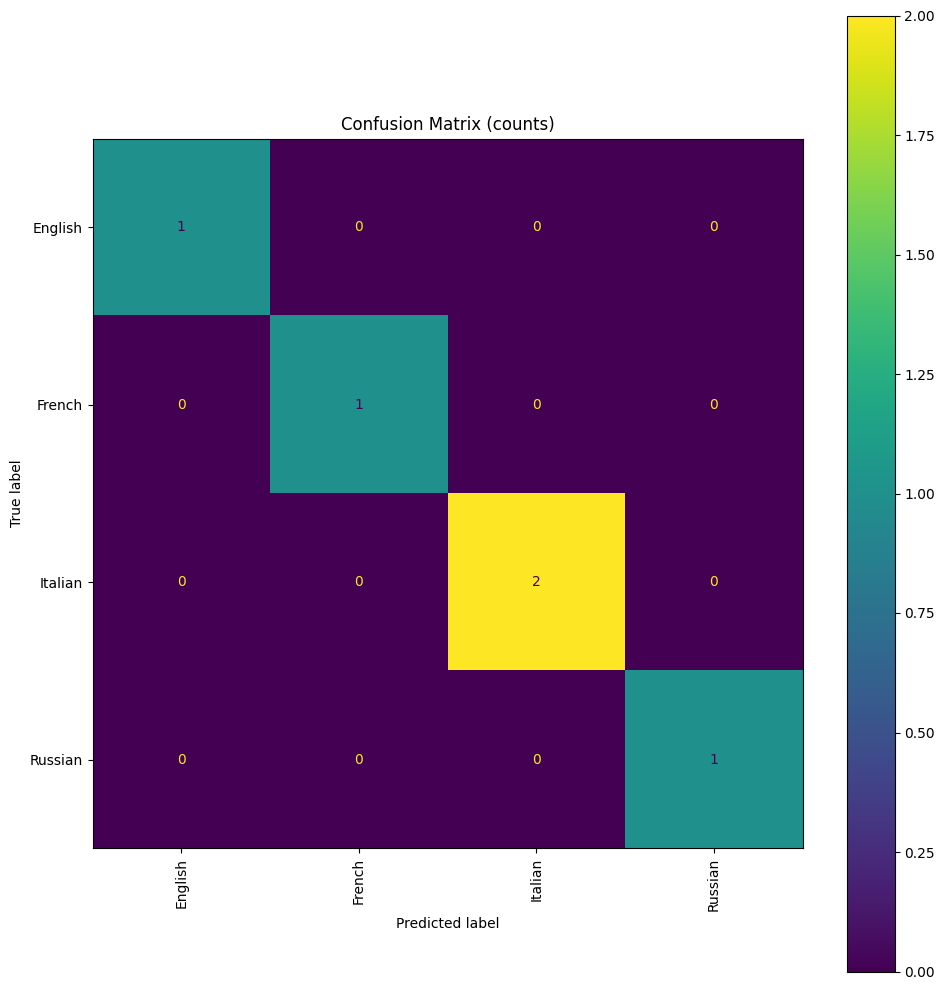

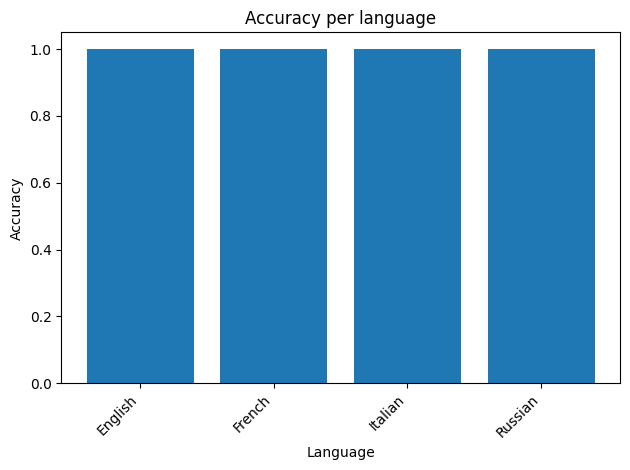

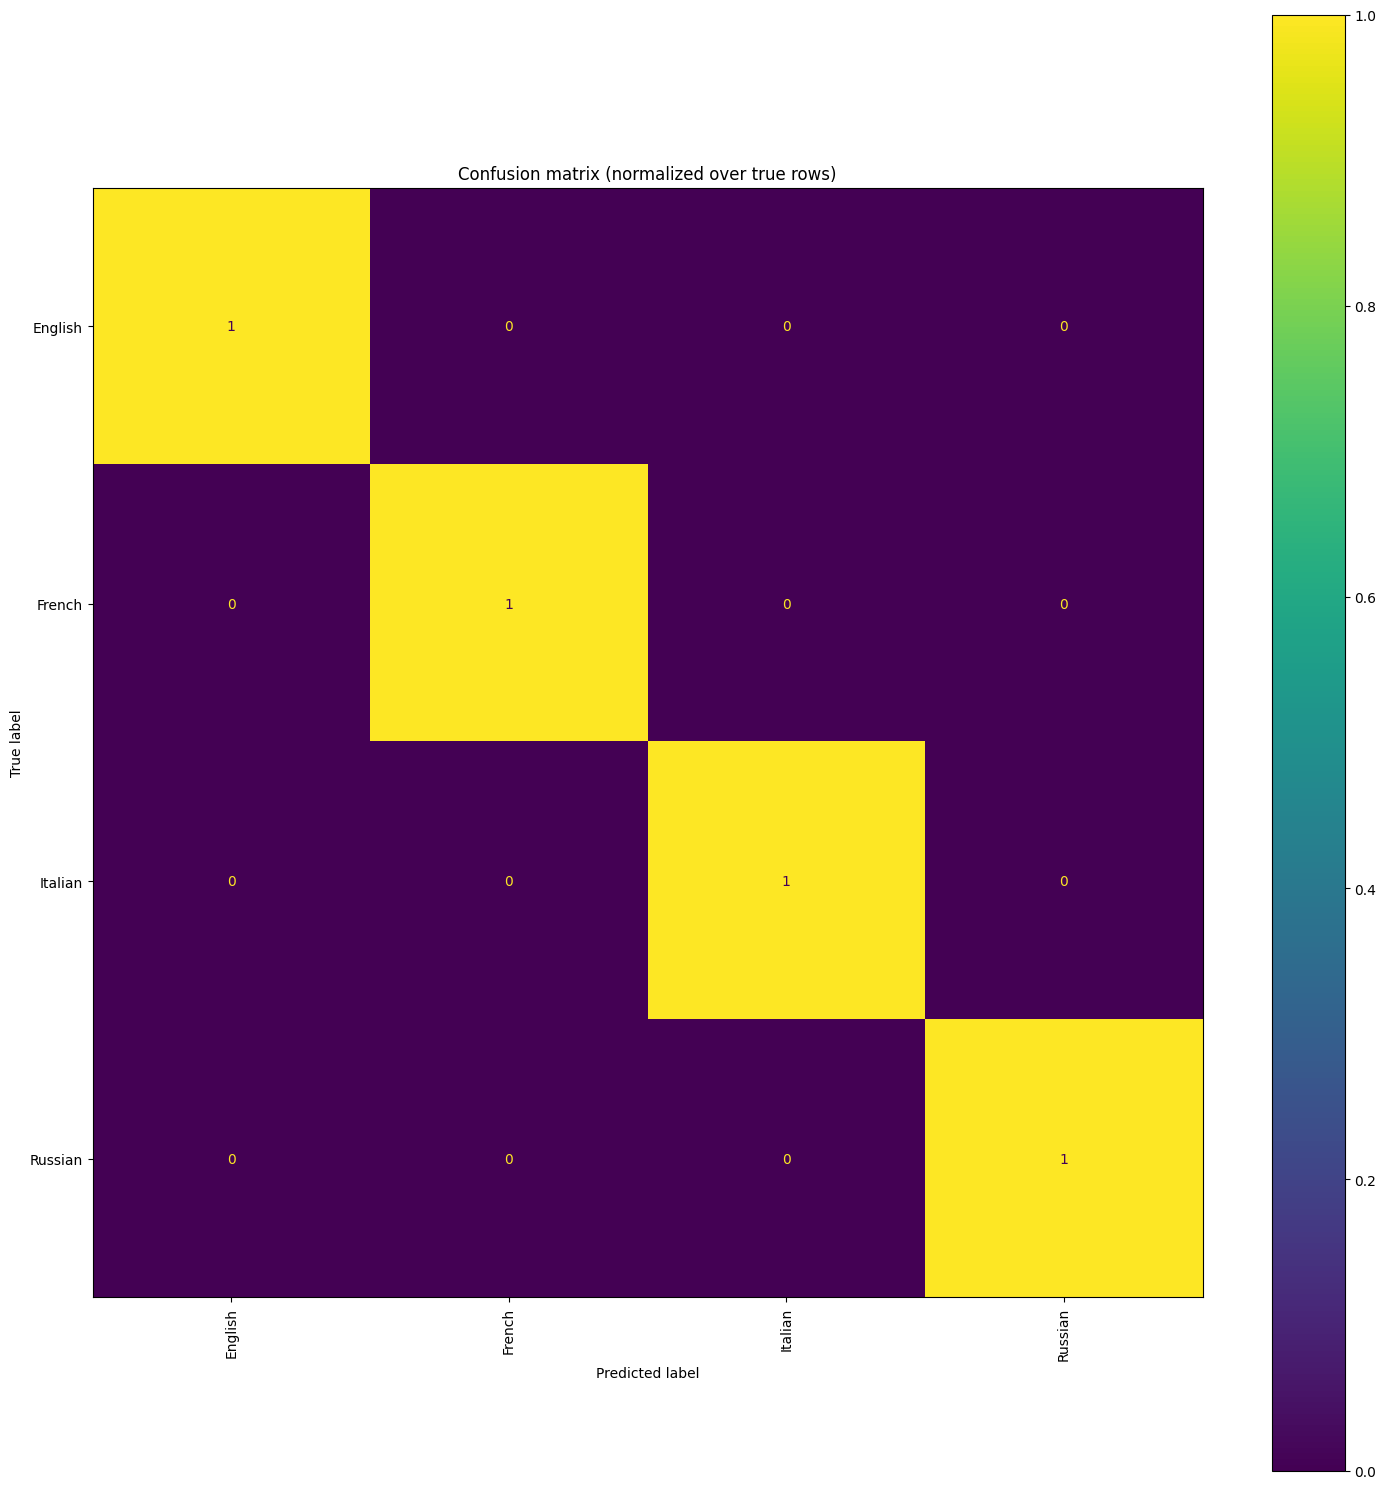

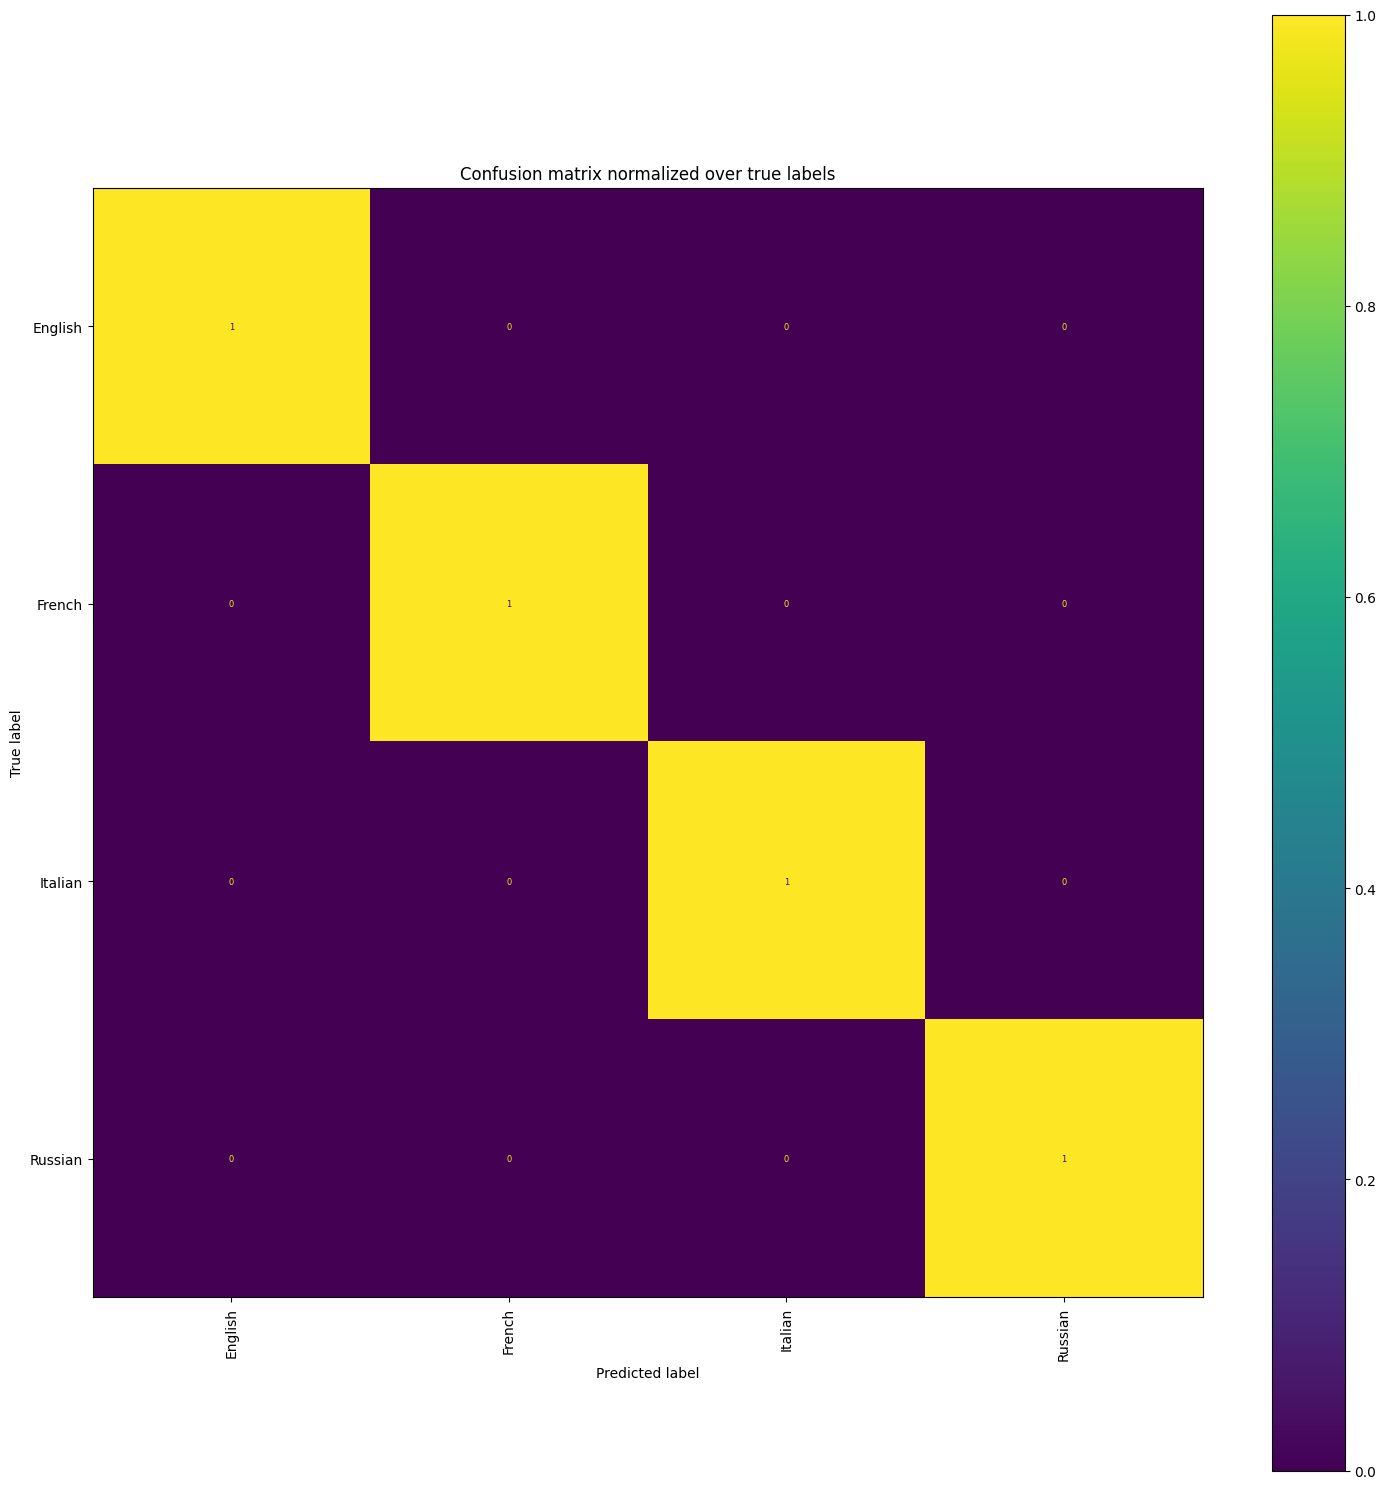

In [26]:
eval_report.make_evaluation_outputs(prediction_output, output_dir, model_id_to_global_id, model.config.id2label, dataset_id_to_global_id)